In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim

from utils import utils
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Codats:
    """
    CoDATS model https://arxiv.org/abs/2005.10996
    """
    def __init__(self, input_size: int, hidden_size: int, lr: float, num_epochs: int, num_domains: int = 1, num_classes: int = 1) -> None:
        self.feature_extractor = utils.Conv1d(input_size=input_size).to(DEVICE)
        self.domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(DEVICE)
        self.task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(DEVICE)
        self.criterion = nn.BCELoss()

        self.feature_optimizer = optim.Adam(self.feature_extractor.parameters(), lr=lr)
        self.domain_optimizer = optim.Adam(self.domain_classifier.parameters(), lr=lr)
        self.task_optimizer = optim.Adam(self.task_classifier.parameters(), lr=lr)
        self.num_epochs = num_epochs

    def fit(self, source_loader: torch.utils.data.dataloader.DataLoader, target_loader: torch.utils.data.dataloader.DataLoader,
            test_target_X: torch.Tensor, test_target_y_task: torch.Tensor) -> None:
        self.feature_extractor, self.task_classifier, _ = utils.fit(
            source_loader, target_loader, test_target_X, test_target_y_task,
            self.feature_extractor, self.domain_classifier, self.task_classifier, self.criterion,
            self.feature_optimizer, self.domain_optimizer, self.task_optimizer,
            num_epochs=self.num_epochs, do_plot=True
        )

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        pred_y_task = self.task_classifier(self.feature_extractor(x))
        pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
        return pred_y_task

In [3]:
source_idx = 2
season_idx = 0

train_source_X = pd.read_csv(f"./deep_occupancy_detection/data/{source_idx}_X_train.csv")
train_source_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{source_idx}_Y_train.csv")[train_source_X.Season == season_idx]
train_source_X = train_source_X[train_source_X.Season == season_idx]

target_prime_X = train_source_X.copy()
tmp_list = [i for i in range(18, 44, 1)]
tmp_list += [12, 13, 14, 15, 16, 17]
tmp_list = tmp_list * int(train_source_X.shape[0]/32)
target_prime_X["Time"] = tmp_list
target_prime_y_task = train_source_y_task

train_source_y_task = train_source_y_task.values.reshape(-1)
target_prime_y_task = target_prime_y_task.values.reshape(-1)

In [4]:
train_source_X

,Energy,Season,Time
2176,168649.947,0,12
2177,169192.356,0,13
2178,168560.052,0,14
2179,130375.163,0,15
2180,132788.967,0,16
...,...,...,...
3131,996765.945,0,39
3132,1305499.967,0,40
3133,886801.848,0,41
3134,991335.091,0,42


In [5]:
target_X, target_y_task = target_prime_X, target_prime_y_task

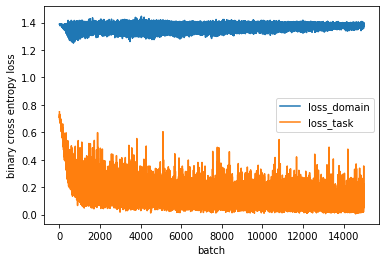

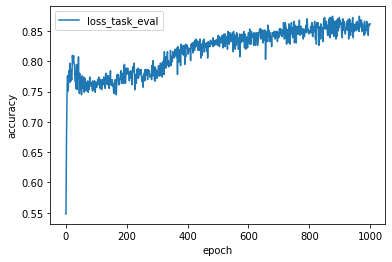

In [6]:
scaler = preprocessing.StandardScaler()
train_source_X = scaler.fit_transform(train_source_X)
target_X = scaler.fit_transform(target_X)
train_source_X, train_source_y_task = utils.apply_sliding_window(train_source_X, train_source_y_task, filter_len=6)
target_X, target_y_task = utils.apply_sliding_window(target_X, target_y_task, filter_len=6)
train_target_X, test_target_X, train_target_y_task, test_target_y_task = train_test_split(target_X, target_y_task, test_size=0.5, shuffle=False)
source_loader, target_loader, _, _, _, _ = utils.get_loader(train_source_X, train_target_X, train_source_y_task, train_target_y_task, shuffle=True)
# TODO: Update utils.get_loader's docstring

test_target_X = torch.tensor(test_target_X, dtype=torch.float32)
test_target_y_task = torch.tensor(test_target_y_task, dtype=torch.float32)
test_target_X = test_target_X.to(DEVICE)
test_target_y_task = test_target_y_task.to(DEVICE)


## CoDATS fit, predict
codats = Codats(input_size=train_source_X.shape[2], hidden_size=128, lr=0.0001, num_epochs=1000)
codats.fit(source_loader, target_loader, test_target_X, test_target_y_task)
pred_y_task = codats.predict(test_target_X)

pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == test_target_y_task) / test_target_y_task.shape[0]

In [7]:
print(f"Target Prime Accuracy: {acc}")

Target Prime Accuracy: 0.8619246482849121
